### *Variables Générales et Imports*

In [4]:
import urllib.request
import os
import json
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.cluster import KMeans
from PIL import Image


QUERY_LIMIT = 3
DATA_JSON_PATH = "data.json"
USERS_JSON_PATH = "users.json"

IMAGE_DATATYPES = ["label","date","model","colors","orientation","taille","tags"]
USERS_PREFSTYPES = ["id","colors","orientation","sizes","tags","imagesLiked"]
IMAGE_SIZES = ["Grande","Moyenne","Petite","Vignette"]

### *Fonctions*

In [3]:

# USERS FUNCTIONS 

def createUser(id : str):
    columns = USERS_PREFSTYPES
    row = [[id,[],None,[],[],[]]]
    newData = pd.DataFrame(row, columns= columns)

    try :
        userDataFrame = pd.read_json(USERS_JSON_PATH)
    except FileNotFoundError :
        userDataFrame = resetUsersDataFrame()
        
    if not (id in list(userDataFrame["id"])):
        userDataFrameChanged = pd.concat([userDataFrame,newData],ignore_index=True)
        saveUserDataFrame(userDataFrameChanged)
    else :
        print("User already exist")

def deleteUser(id : str):
    userDataFrame = pd.read_json(USERS_JSON_PATH)
    if id in list(userDataFrame["id"]):
        index = list(userDataFrame["id"]).index(id)
        userDataFrame = userDataFrame.drop([index])
    saveUserDataFrame(userDataFrame)

def resetUsersDataFrame():
    columns = USERS_PREFSTYPES
    userDataFrame = pd.DataFrame(columns = columns)
    saveUserDataFrame(userDataFrame)
    return userDataFrame

def getUserPreferences(id : str):
    userDataFrame = pd.read_json(USERS_JSON_PATH)
    prefs = []
    if id in list(userDataFrame["id"]):
        index = list(userDataFrame["id"]).index(id)
        prefs = userDataFrame.iloc[index]
    return(prefs)


def saveUserDataFrame(userDataFrame):
    usersJSON = open(USERS_JSON_PATH, "w")
    usersJSON.write(userDataFrame.to_json())
    usersJSON.close()


def getUserDataFrame():
    return pd.read_json(USERS_JSON_PATH)




## Collecte de données

### Collecte des images

In [18]:
# Récupération de la Query
url = "https://query.wikidata.org/sparql?query=SELECT%20%3Fitem%20%3FitemLabel%20%3Fimage%0AWHERE%0A%7B%0A%3Fitem%20wdt%3AP31%20wd%3AQ144%20.%0A%3Fitem%20wdt%3AP18%20%3Fimage%0ASERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22%5BAUTO_LANGUAGE%5D%2Cen%22%20%7D%0A%7D%0ALIMIT%20"+str(QUERY_LIMIT)+"&format=json"
response = urllib.request.urlopen(url)
responseJSON  = json.load(response)

# Création de la dataframe
columns   = ["label","format","link","path"]
dataArray = []
for data in responseJSON["results"]["bindings"]:
    link = data["image"]["value"]
    label = data["itemLabel"]["value"]
    format = str(link).split(".")[-1]
    path = "./images/" + label +"."+ format
    dataArray.append([label,format,link,path])

dataframe = pd.DataFrame(dataArray, columns= columns)


# Vidage du dossier images
files = glob.glob('./images/*')
for f in files:
    os.remove(f)

sizes = []
# Telechargement des images
length = len(dataframe.index)
for i in range(length):
    link = dataframe._get_value(i,'link')
    path = dataframe._get_value(i,'path')
    urllib.request.urlretrieve(link, path)

    img = Image.open(path)
    sizes.append(np.array(img.size))
    img.close()

dataframe["résolution"] = sizes

# Création du fichier JSON 
file = open(DATA_JSON_PATH, "w") 
file.write(dataframe.to_json())
file.close()

dataframe

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

### Récupération des Métadonnées EXIF

In [5]:
dataframe = pd.read_json(DATA_JSON_PATH)

tags = ["label","date","model"]
tagsWantedEXIF = [306,272]
dataEXIF = []
    
length = len(dataframe.index)
for i in range(length):
    path = dataframe._get_value(i,'path')
        
    image = Image.open(path)
    exif = image.getexif()

        

    array = [dataframe._get_value(i,'label')]
    for tag in tagsWantedEXIF:
        array.append(exif.get(tag))
    dataEXIF.append(array)
    
dataframeEXIF = pd.DataFrame(dataEXIF, columns=tags)
for c in dataframeEXIF.columns :
    dataframe[c] = dataframeEXIF[c]
        
file = open(DATA_JSON_PATH, "w")
file.write(dataframe.to_json())
file.close()

dataframeEXIF

,label,date,model
0,Blondi,None,None


## Étiquetage et annotation

### Couleurs prédominantes

In [6]:
N = 3
resolution = 100

dataframe = pd.read_json(DATA_JSON_PATH)

colors = []
distributions = []

for path in dataframe.path:
    img = Image.open(path).convert("RGB")
    imgArray = np.array(img.getdata())[::10]
    img.close()
    imgDataframe = pd.DataFrame(imgArray, columns=["red","green","blue"])

    model=KMeans(n_clusters= N, n_init='auto')
    model.fit(imgDataframe)

    distribution = []
    total = len(list(model.labels_))
    for i in range(N):
        distribution.append(list(model.labels_).count(i)/total)
    distributions.append(distribution)

    meansList = (np.floor(model.cluster_centers_)).tolist()

    colors.append(meansList)

dataframe["colors"] = colors
dataframe["colorsDistribution"] = distributions

# Création du fichier JSON 
colorTable = open(DATA_JSON_PATH, "w")
colorTable.write(dataframe.to_json())
colorTable.close()

dataframe


,label,format,link,path,résolution,date,model,colors,colorsDistribution
0,Blondi,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Blondi.jpg,"[1329, 1201]",NaT,NaN,"[[70.0, 70.0, 70.0], [227.0, 227.0, 227.0], [1...","[0.20461992444224467, 0.6392399115360278, 0.15..."


> ### Option : affichage des couleurs prédominantes

([<matplotlib.patches.Wedge at 0x1cb459a2c40>,
 [Text(0.8804411072729575, 0.6594114471435637, ''),
  Text(-1.0872666173525842, -0.16688709593815004, ''),
  Text(0.9702922599318131, -0.5182016309472742, '')])

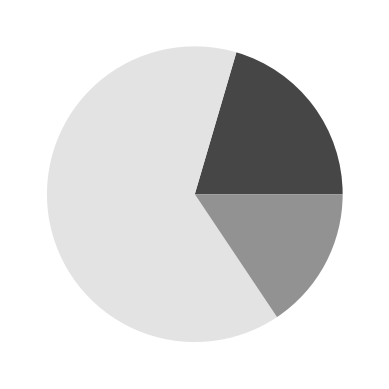

In [7]:
colors = np.array(dataframe["colors"][0])/255
distribution = np.array(dataframe["colorsDistribution"][0])*100

fig = plt.figure()
ax = fig.add_subplot()

ax.pie(distribution, colors = colors)

### Orientation et Taille

In [91]:
dataframe = pd.read_json(DATA_JSON_PATH)

orientations = []
tailles = []
for taille in dataframe["résolution"]:
    # Orientation
    if taille[0] > taille[1]:
        orientations.append("Paysage")
    else:
        orientations.append("Portrait")
    
    nbrPixel = taille[0] * taille[1]
 
    if   nbrPixel >= 1920*1080:
        tailles.append("Grande")
    elif nbrPixel >= 1280*720:
        tailles.append("Moyenne")
    elif nbrPixel >= 720*480:
        tailles.append("Petite")
    else :
        tailles.append("Vignette")
    

dataframe["orientation"] = orientations
dataframe["taille"] = tailles

# Création du fichier JSON 
colorTable = open(DATA_JSON_PATH, "w")
colorTable.write(dataframe.to_json())
colorTable.close()


### Autres

In [7]:
dataframe = pd.read_json(DATA_JSON_PATH)

dataframe["tags"] = [[] for i in range(len(dataframe["label"]))]

colorTable = open(DATA_JSON_PATH, "w")
colorTable.write(dataframe.to_json())
colorTable.close()

## Analyse des données

### Création d'utilisateur

In [114]:
createUser("john")
getUserDataFrame()

,id,colors,orientation,sizes,tags,imagesLiked
0,john,[],NaN,[],[],[]


### Suppression d'utilisateur

In [110]:
deleteUser("john")
getUserDataFrame()

,id,colors,orientation,sizes,tags,imagesLiked


### Ajouter manuellement une image likée pour un utilisateur

In [34]:
poollSize = 5

dataDataFrame = pd.read_json(DATA_JSON_PATH)
userDataFrame = pd.read_json(USERS_JSON_PATH)

userId = ""
while not userId in list(userDataFrame["id"]) :
    userId = input("user Id :")

i = random.randint(0,len(dataDataFrame["label"])-1)
while i in userDataFrame["imagesLiked"][list(userDataFrame["id"]).index(userId)] :
    i = random.randint(0,len(dataDataFrame["label"])-1)

img = Image.open(dataDataFrame["path"][i]).convert('RGB')
img.show()

invalid = True
while invalid:
    ans = input("Do you like this image ? [y/n]").capitalize()
    invalid = ans not in ["Y","N"]
liked = ans == "Y"  
if liked :
    (userDataFrame["imagesLiked"][list(userDataFrame["id"]).index(userId)]).append(i)

saveUserDataFrame(userDataFrame)
userDataFrame


,id,colors,orientation,sizes,tags,imagesLiked
0,john,[],NaN,[],[],"[4, 2]"


### Ajouter Aléatoirement des images likées à un utilisateur

In [115]:
dataDataFrame = pd.read_json(DATA_JSON_PATH)
userDataFrame = pd.read_json(USERS_JSON_PATH)

userId = ""
while not userId in list(userDataFrame["id"]) :
    userId = input("user Id :")
userIndex = list(userDataFrame["id"]).index(userId)

nbr = int(input("nombre d'images :"))
if nbr > (newNbr := QUERY_LIMIT - len(list(userDataFrame["imagesLiked"][userIndex]))):
    nbr = newNbr

imagesIndex = []
for n in range(nbr):
    i = random.randint(0,len(dataDataFrame["label"])-1)
    while i in (userDataFrame["imagesLiked"][userIndex] or imagesIndex) :
        i = random.randint(0,len(dataDataFrame["label"])-1)
    imagesIndex.append(i)

userDataFrame["imagesLiked"][userIndex] += imagesIndex

saveUserDataFrame(userDataFrame)
userDataFrame

C:\Users\hugue\AppData\Local\Temp\ipykernel_18952\1633545535.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userDataFrame["imagesLiked"][userIndex] += imagesIndex


,id,colors,orientation,sizes,tags,imagesLiked
0,john,[],NaN,[],[],"[17, 16, 0, 15, 12, 7, 5, 6, 10, 11]"


### Calcul des préférences utilisateur

In [116]:
dataDataFrame = pd.read_json(DATA_JSON_PATH)
userDataFrame = pd.read_json(USERS_JSON_PATH)

userId = "john"

index = list(userDataFrame["id"]).index(userId)
imagesLikedindex = list(userDataFrame["imagesLiked"][index])

if imagesLikedindex != []:
        
    colors = []
    orientations = []
    sizes = []
    tags = []

    # Collecte des Informations des Images Likées
    for i in imagesLikedindex:
        colors += list(dataDataFrame["colors"])[i]
        orientations += list(dataDataFrame["orientation"])[i]
        sizes.append(list(dataDataFrame["taille"])[i])
        tags += list(dataDataFrame["tags"])[i]

    # Couleurs préférées
    userDataFrame["colors"][index] = colors


    # Orientation préféré
    if orientations.count("Paysage") > len(orientations)//2 :
        userDataFrame["orientation"][index] = "Paysage"
    else:
        userDataFrame["orientation"][index] = "Portrait"

    # Tailles préférées
    t1 = 0
    t2 = 0
    for i,taille in enumerate(IMAGE_SIZES) :
        if (c := sizes.count(taille)) > t1 :
            t1 = i
        elif (c := sizes.count(taille)) > t2 and c != t1:
            t2 = i
    userDataFrame["sizes"][index] = [IMAGE_SIZES[t1],IMAGE_SIZES[t2]]

    # Tags préférées
    userDataFrame["tags"][index] = []

    saveUserDataFrame(userDataFrame)
getUserDataFrame()

C:\Users\hugue\AppData\Local\Temp\ipykernel_18952\3816945602.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userDataFrame["colors"][index] = colors
C:\Users\hugue\AppData\Local\Temp\ipykernel_18952\3816945602.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userDataFrame["orientation"][index] = "Portrait"


,id,colors,orientation,sizes,tags,imagesLiked
0,john,"[[245.0, 244.0, 241.0], [172.0, 140.0, 112.0],...",Portrait,"[Vignette, Grande]",[],"[17, 16, 0, 15, 12, 7, 5, 6, 10, 11]"


## Visualisation des données

### Images par catégorie

In [8]:
dataDataFrame = pd.read_json(DATA_JSON_PATH)
userDataFrame = pd.read_json(USERS_JSON_PATH)

df = dataDataFrame

scope = ""
while scope not in ["all"]+list(userDataFrame["id"]):
     scope = input()
if scope in list(userDataFrame["id"]):
     df = dataDataFrame.iloc[userDataFrame["imagesLiked"]]

category = ""
while category not in IMAGE_DATATYPES:
     category = input("Catégorie :")
distribution = []

for item in dataDataFrame[category]:
    if (item != None) and (item != []):
        if category == 'date':
                distribution.append(str(item).split(':')[0])
        else:
            distribution.append(str(item))
    else :
        distribution.append("Indéterminé")

plt.hist(distribution, rwidth = 0.8, color = "orange")

ValueError: Expected object or value

### Caractéristiques des couleurs

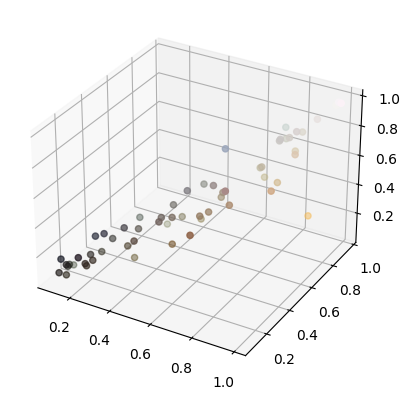

In [127]:
dataDataFrame = pd.read_json(DATA_JSON_PATH)

category = "colors"
distribution = []

for item in dataDataFrame[category]:
    if (item != None) and (item != []):
        distribution += item
    else :
        distribution.append("Indéterminé")
distribution = np.array(distribution)

r = [c[0]/255  for c in distribution]
g = [c[1]/255  for c in distribution]
b = [c[2]/255  for c in distribution]
c = distribution/255

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(r,g,b,c = c)

## Système de Recommandation

In [126]:
dataDataFrame = pd.read_json(DATA_JSON_PATH)
userPrefs = getUserPreferences("john")
recommandation = pd.DataFrame()

if list(userPrefs) != [] :
    
    if userPrefs['sizes'] != [] :
        for size in userPrefs['sizes']:
            recommandation = pd.concat([recommandation,dataDataFrame.loc[dataDataFrame['taille'] == size]])

    if userPrefs['orientation'] != None :
        recommandation = recommandation.loc[recommandation['orientation'] == userPrefs['orientation']]
        
else:
    recommandation = dataDataFrame
    
recommandation = recommandation.sort_index()

recommandation

,label,format,link,path,résolution,date,model,colors,orientation,taille,tags
0,Negro Matapacos,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Negro Matapacos.jpg,"[3801, 5701]",2020:03:03 23:00:15,NIKON D5200,"[[32.0, 32.0, 26.0], [187.0, 181.0, 154.0], [1...",Portrait,Grande,[]
1,Néro,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Néro.jpg,"[480, 640]",None,None,"[[192.0, 182.0, 139.0], [90.0, 76.0, 33.0], [1...",Portrait,Vignette,[]
2,Thunder the Dog,jpeg,http://commons.wikimedia.org/wiki/Special:File...,./images/Thunder the Dog.jpeg,"[263, 388]",2020:03:17 11:30:18,None,"[[159.0, 145.0, 117.0], [217.0, 205.0, 178.0],...",Portrait,Vignette,[]
5,Dylan,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Dylan.jpg,"[235, 380]",None,None,"[[32.0, 35.0, 27.0], [202.0, 198.0, 197.0], [1...",Portrait,Vignette,[]
7,Kratu,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Kratu.jpg,"[1613, 1613]",2020:11:29 14:18:27,SM-A520F,"[[68.0, 67.0, 64.0], [152.0, 140.0, 138.0], [2...",Portrait,Grande,[]
8,Peter the Great,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Peter the Great.jpg,"[1280, 1851]",None,None,"[[244.0, 187.0, 89.0], [85.0, 96.0, 87.0], [25...",Portrait,Grande,[]
11,Médor,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Médor.jpg,"[4824, 6176]",None,None,"[[161.0, 145.0, 126.0], [220.0, 199.0, 177.0],...",Portrait,Grande,[]
12,Commander,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Commander.jpg,"[3327, 4741]",2022:02:16 18:25:01,ILCE-1,"[[120.0, 106.0, 94.0], [205.0, 206.0, 194.0], ...",Portrait,Grande,[]
16,Sallie Ann Jarrett,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Sallie Ann Jarrett.jpg,"[280, 280]",None,None,"[[248.0, 244.0, 247.0], [61.0, 61.0, 74.0], [1...",Portrait,Vignette,[]
19,Q24876723,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Q24876723.jpg,"[240, 300]",None,None,"[[60.0, 57.0, 45.0], [190.0, 179.0, 158.0], [1...",Portrait,Vignette,[]
